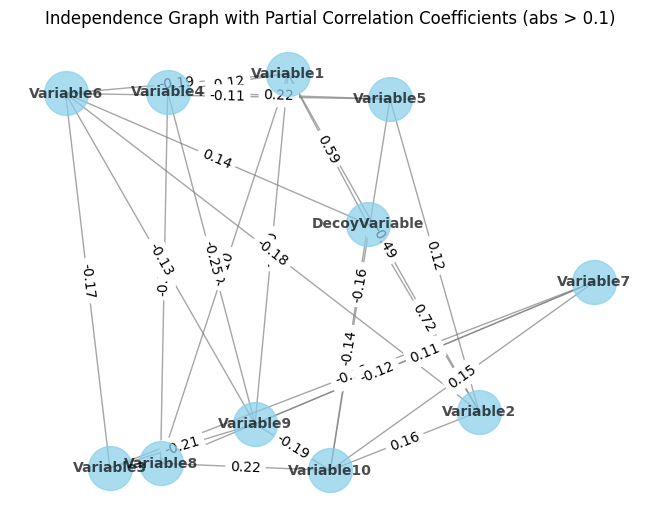

In [27]:
import pandas as pd
import numpy as np
import pingouin as pg
import networkx as nx
import matplotlib.pyplot as plt

# サンプルデータの作成
np.random.seed(42)  # 再現性を確保するためにシードを設定

# 偽装された変数を含む10個の変数を生成
num_variables = 10

# 表示するノード間の最低偏相関係数を指定
thres = 0.1

# 通常の変数
normal_variables = {f'Variable{i}': np.random.normal(0, 1, 100) for i in range(1, num_variables + 1)}

# 偽装された変数（他の変数との組み合わせ）
decoy_variable = np.random.normal(0, 1, 100) + normal_variables['Variable1'] + normal_variables['Variable2']

# データフレームの作成
data = {**normal_variables, 'DecoyVariable': decoy_variable}
df = pd.DataFrame(data)

# 独立グラフの作成
G = nx.Graph()

# 変数間の偏相関を計算し、エッジを追加
for var1 in df.columns:
    for var2 in df.columns:
        if var1 != var2:
            partial_corr = pg.partial_corr(df, x=var1, y=var2, covar=list(set(df.columns) - {var1, var2}))
            partial_corr_value = partial_corr['r'].values[0]
            G.add_edge(var1, var2, weight=partial_corr_value)

# エッジの重みが閾値未満のものを削除
edges_to_remove = [(var1, var2) for var1, var2, weight in G.edges(data='weight') if abs(weight) <= thres]
G.remove_edges_from(edges_to_remove)

# ノードの位置を設定 (spring_layoutを使用)
pos = nx.spring_layout(G, seed=42)  # seedを指定して再現性を確保

# ノードとエッジの描画
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1000, node_color='skyblue', font_size=10, font_color='black', edge_color='gray', linewidths=1, alpha=0.7)

# エッジの重み（偏相関係数）を表示
edge_labels = {(i, j): f"{partial_corr_value:.2f}" for i, j, partial_corr_value in G.edges(data='weight')}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# グラフの描画
plt.title(f'Independence Graph with Partial Correlation Coefficients (abs > {thres})')
plt.show()